# Covid data exploratory analysis

# Dictionary for quick pathway-molecule search

In [1]:
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import tensorly as tl
import torch
import pickle
from tensorly.decomposition import parafac
import tlviz
import pathintegrate
from evaluation_metrics import degeneracy_score_adapted, df_rank_evaluation
from split_half_pathway_fun import split_half, cal_fms, plt_fms
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from pathway_feature_selection import bootstrap_feature_select_pr1, feature_select_bs_ci, significant_pathways, harmonic_pvalue,combined_pseudoz, significant_pseudoz, plot_zscore_distribution

In [2]:
metab = pathintegrate.load_example_data('metabolomics')
prot = pathintegrate.load_example_data('proteomics')

In [3]:
prot_conversion_table = pd.read_csv("/Users/yalilyu/Desktop/Covid/proteomics_metadata.csv",dtype=str)

In [4]:
mapping_dict = dict(zip(prot_conversion_table['uniprot'],prot_conversion_table['gene_name']))
prot.rename(columns=lambda x:mapping_dict.get(x,x), inplace=True)


In [5]:
# retrieve only the first gene name for columns with multiple gene names
prot.columns=[col.split(' ')[0] for col in prot.columns]
prot

,LGALS9,TNFRSF10A,AGRP,TNFRSF10B,TNFRSF13B,FIGF,DKK1,REN,PDGFB,GH1,...,RCOR1,CA14,STX8,PRKAB1,MAP4K5,NUB1,ENTPD2,MAGED1,GPR56,Group
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV092-BL,10.499046,4.108639,6.260154,6.722554,10.504367,8.545390,10.724486,8.664588,11.701879,8.966646,...,3.074093,2.639784,5.146036,2.937521,8.433509,3.274849,2.070798,1.003806,3.503626,Mild
INCOV107-BL,9.974258,3.518560,4.698671,5.985321,9.580609,8.099680,11.021719,8.052122,12.064962,5.527914,...,3.072335,2.361624,6.274084,3.868208,8.934732,4.995750,1.731189,1.089978,4.399312,Mild
INCOV020-BL,11.030835,5.251186,6.845172,9.054961,11.023916,7.416310,9.568452,10.709513,8.344538,10.215193,...,3.455134,1.290294,2.154327,2.000634,4.544658,0.850766,2.234723,0.524290,4.840999,Severe
INCOV035-BL,10.784361,4.869835,5.551323,7.855721,10.356665,7.401949,9.968144,8.954985,10.741812,10.864942,...,2.951877,2.613248,3.618144,2.834577,6.816611,1.666262,1.785225,0.164508,2.451285,Severe
INCOV122-BL,10.117736,3.378996,4.411282,5.230120,9.533394,7.851850,11.461373,6.477619,12.242743,4.508236,...,2.594084,2.140240,5.903346,4.021954,8.946893,4.720346,1.060657,0.972700,1.404552,Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV030-BL,10.559775,5.223258,4.572899,8.005347,9.955384,7.712653,10.582210,7.901934,11.650965,8.730996,...,2.300311,0.283069,2.796551,0.944974,6.141287,1.232355,0.847794,-0.539917,1.067057,Severe
INCOV102-BL,9.939301,3.691823,6.259292,6.018546,10.016870,8.651398,10.271883,8.339251,11.329210,8.882110,...,2.719117,3.224118,5.374915,3.017665,8.364873,2.898821,1.452894,0.896790,1.846168,Mild
INCOV027-BL,11.060385,4.825185,4.609743,6.663861,9.655186,7.566332,10.431308,7.373610,11.051030,9.926305,...,3.053454,1.060538,4.326423,2.301759,7.903735,2.613365,1.413523,0.916418,2.881401,Severe


In [6]:
with open('covid_processed_sample_data.pkl','rb') as f:
    processed_sample_data = pickle.load(f)

with open('metadata_binary.pkl','rb') as f:
    metadata_binary = pickle.load(f)

with open('metab_kpca.pkl','rb') as f:
    metab_kpca = pickle.load(f)

with open('prot_kpca.pkl','rb') as f:
    prot_kpca = pickle.load(f)

with open('metab_filtered_kpca.pkl','rb') as f:
    metab_filtered_kpca = pickle.load(f)

with open('prot_filtered_kpca.pkl','rb') as f:
    prot_filtered_kpca = pickle.load(f)

with open('common_pathways.pkl','rb') as f:
    common_pathways = pickle.load(f)

with open('parafac1_pathways_df.pkl','rb') as f:
    parafac1_pathways_df = pickle.load(f)

with open('reactome_updated.pkl','rb') as f:
    prot_pathways = pickle.load(f)

In [7]:
metab_kpca.shape

(127, 149)

In [8]:
prot_kpca.shape

(127, 386)

In [9]:
prot_s = prot.iloc[:,:-1]

In [10]:
metab_pathways  = sspa.process_reactome(organism="Homo sapiens")

In [11]:
metab_path_dict = sspa.utils.pathwaydf_to_dict(metab_pathways)

In [12]:
prot_path_dict = sspa.utils.pathwaydf_to_dict(prot_pathways)

In [13]:
# Counting average number of molecules present in a pathway for metab / prot

# metab

metab_path_num_dict = {}
for pathwayid, molecules in metab_path_dict.items():
    if pathwayid in metab_kpca.columns:
        count = 0
        for molecule in molecules:
            if molecule in metab.columns:
                count +=1
        metab_path_num_dict[pathwayid] = count

metab_path_num_df = pd.DataFrame.from_dict(metab_path_num_dict,orient='index')
num_metab_array = np.array(metab_path_num_df[metab_path_num_df.iloc[:,0]!=0])
ave_metab  = np.mean(num_metab_array)
ave_metab_std = np.std(num_metab_array)
ave_metab = round(ave_metab, 1)
print(f"There are on average {ave_metab} metabolites present in metabolomics pathways")

# prot
prot_path_num_dict = {}
for pathwayid, molecules in prot_path_dict.items():
    if pathwayid in prot_kpca.columns:
        count = 0
        for molecule in molecules:
            if molecule in prot.columns:
                count +=1
        prot_path_num_dict[pathwayid] = count

prot_path_num_df = pd.DataFrame.from_dict(prot_path_num_dict,orient='index')
num_prot_array = np.array(prot_path_num_df[prot_path_num_df.iloc[:,0]!=0])
ave_prot = np.mean(num_prot_array)
ave_prot_std = np.std(num_prot_array)
ave_prot = round(ave_prot, 1)
print(f"There are on average {ave_prot} proteins present in proteomics pathways")
print(f"Stds metab: {ave_metab_std}, {ave_prot_std}")

There are on average 7.1 metabolites present in metabolomics pathways
There are on average 8.7 proteins present in proteomics pathways
Stds metab: 8.679796000481378, 14.228394615978619


In [14]:
np.median(num_metab_array)

4.0

In [15]:
np.median(num_prot_array)

4.0

(array([126.,  15.,   4.,   1.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([ 3. , 10.9, 18.8, 26.7, 34.6, 42.5, 50.4, 58.3, 66.2, 74.1, 82. ]),
 <BarContainer object of 10 artists>)

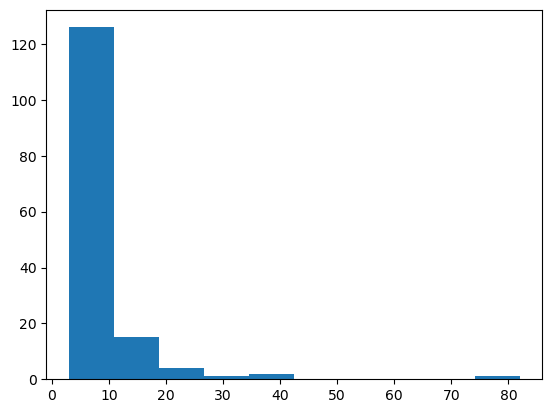

In [16]:
plt.hist(num_metab_array)

(array([346.,  26.,   7.,   3.,   1.,   1.,   0.,   1.,   0.,   1.]),
 array([  3. ,  18.8,  34.6,  50.4,  66.2,  82. ,  97.8, 113.6, 129.4,
        145.2, 161. ]),
 <BarContainer object of 10 artists>)

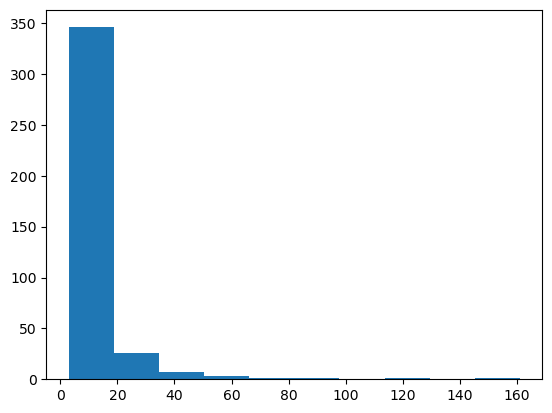

In [17]:
plt.hist(num_prot_array)

In [18]:
metab.columns

Index(['1372', '16610', '1-methylnicotinamide', '72665', '30915', '37373',
       '16831', '545959', '17050', '16359',
       ...
       '3-carboxy-4-methyl-5-pentyl-2-furanpropionate (3-CMPFP)**',
       '3-hydroxystachydrine*', '28238', '76341', '89312',
       '2-naphthol sulfate',
       '2,3-dihydroxy-5-methylthio-4-pentenoate (DMTPA)*',
       '3-bromo-5-chloro-2,6-dihydroxybenzoic acid*', '17861', '89188'],
      dtype='object', length=452)

In [19]:
# print metab and protein names that are mapped to pathways
# metab
metab_mapped_to_path = []
for metabolite in metab.columns:
    # Check if metabolite is in any of the lists within the dict values
    if any(metabolite in v for v in metab_path_dict.values()):
        metab_mapped_to_path.append(metabolite)

# prot 
prot_mapped_to_path = []
for protein in prot.columns:
    # Check if protein is in any of the lists within the dict values
    if any(protein in v for v in prot_path_dict.values()):
        prot_mapped_to_path.append(protein)

In [20]:
len(metab_mapped_to_path)

93

In [21]:
len(prot_mapped_to_path)

352

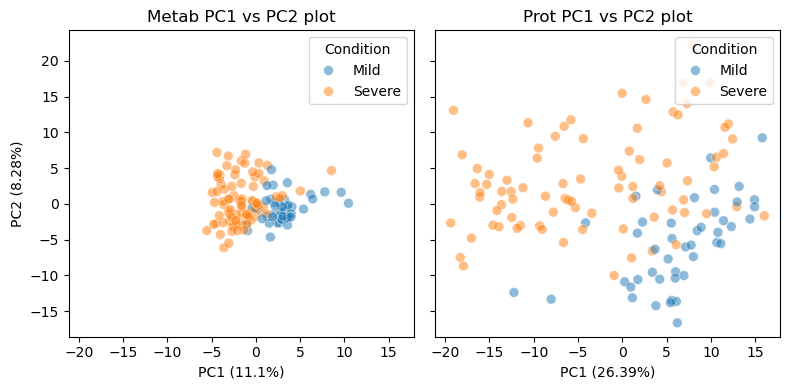

In [22]:
## Only molecules matched to pathways 

metab_scores_norm = pd.DataFrame(StandardScaler().fit_transform(metab[metab_mapped_to_path]), index=metab.index,columns=metab[metab_mapped_to_path].columns)

pca_metab = PCA(n_components=2)
pca_metab_res = pca_metab.fit_transform(metab_scores_norm)

pca_metab.explained_variance_ratio_


prot_scores_norm = pd.DataFrame(StandardScaler().fit_transform(prot_s[prot_mapped_to_path]), index=prot.index,columns=prot_s[prot_mapped_to_path].columns)

pca_prot = PCA(n_components=2)
pca_prot_res = pca_prot.fit_transform(prot_scores_norm)

# determine the variance explained by the first 2 components
pca_prot.explained_variance_ratio_

plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.scatterplot(x=pca_metab_res[:, 0], y=pca_metab_res[:, 1], hue=metadata_binary, ax=ax1, s=50, alpha=0.5)
sns.scatterplot(x=pca_prot_res[:, 0], y=pca_prot_res[:, 1], hue=metadata_binary, ax=ax2, s=50, alpha=0.5)

# Set axis labels
ax1.set_xlabel('PC1 (' + str(round(pca_metab.explained_variance_ratio_[0]*100,2)) + '%)')
ax1.set_ylabel('PC2 (' + str(round(pca_metab.explained_variance_ratio_[1]*100,2)) + '%)')
ax1.set_title('Metab PC1 vs PC2 plot')

ax2.set_xlabel('PC1 (' + str(round(pca_prot.explained_variance_ratio_[0]*100,2)) + '%)')
ax2.set_ylabel('PC2 (' + str(round(pca_prot.explained_variance_ratio_[1]*100,2)) + '%)')
ax2.set_title('Prot PC1 vs PC2 plot')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=['Mild', 'Severe'], title='Condition', loc='upper right')  # Customize legend for ax1
ax2.legend(title='Condition', loc='upper right', handles=handles, labels=['Mild', 'Severe'])  # Same legend for ax2

plt.tight_layout()

plt.show()


In [23]:
metab_present_count = {}
for metabolite in metab_mapped_to_path:
    count = 0 
    for list in metab_path_dict.values():
        if metabolite in list:
            count +=1
    metab_present_count[metabolite] = count


In [24]:
metab_counts = np.array([value for value in metab_present_count.values()])

In [25]:
print(np.mean(metab_counts),np.median(metab_counts))


15.913978494623656 9.0


In [26]:
prot_present_count = {}
for protein in prot_mapped_to_path:
    count = 0 
    for list in prot_path_dict.values():
        if protein in list:
            count +=1
    prot_present_count[protein] = count


In [27]:
prot_counts = np.array([value for value in prot_present_count.values()])

In [28]:
print(np.mean(prot_counts),np.median(prot_counts))


12.607954545454545 8.0


(array([67., 14.,  6.,  2.,  2.,  0.,  0.,  0.,  0.,  2.]),
 array([  3. ,  16.6,  30.2,  43.8,  57.4,  71. ,  84.6,  98.2, 111.8,
        125.4, 139. ]),
 <BarContainer object of 10 artists>)

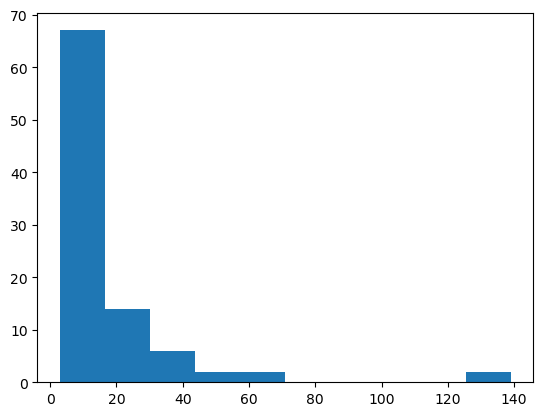

In [29]:
plt.hist(metab_counts)

(array([285.,  47.,   9.,   6.,   1.,   2.,   0.,   0.,   0.,   2.]),
 array([  2. ,  17.8,  33.6,  49.4,  65.2,  81. ,  96.8, 112.6, 128.4,
        144.2, 160. ]),
 <BarContainer object of 10 artists>)

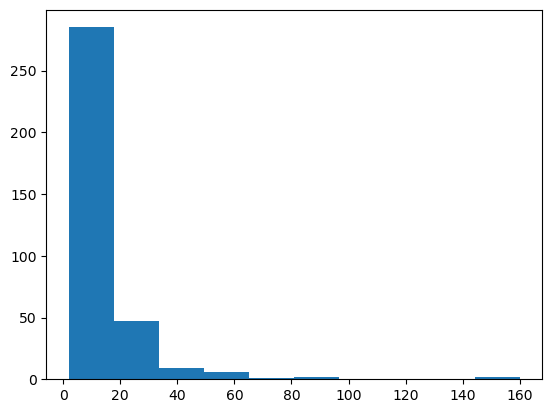

In [30]:
plt.hist(prot_counts)

 'R-HSA-1643685': 'Disease'

In [31]:
intersection = set(prot.columns).intersection(set(prot_path_dict['R-HSA-1643685']))
len(intersection)

73

In [32]:
intersection = set(metab.columns).intersection(set(metab_path_dict['R-HSA-1643685']))
len(intersection)

26

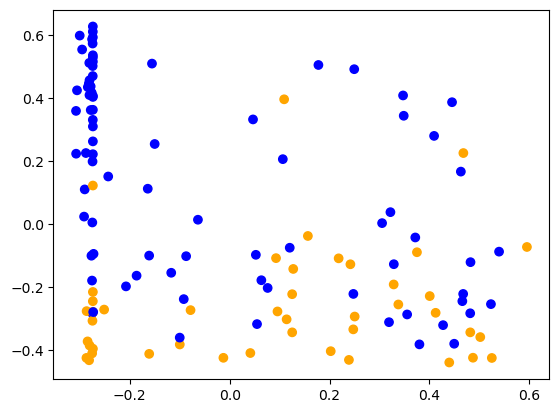

In [33]:
plt.scatter(metab_kpca.loc[:,'R-HSA-1643685'], prot_kpca.loc[:,'R-HSA-1643685'],
            c=['orange' if i ==0 else 'blue' for i in metadata_binary])

 'R-HSA-168256': 'Immune System'

In [34]:
intersection = set(prot.columns).intersection(set(prot_path_dict['R-HSA-168256']))
len(intersection)

161

In [35]:
intersection = set(metab.columns).intersection(set(metab_path_dict['R-HSA-168256']))
print(intersection)

{'16349', '17489', '15354', '17189'}


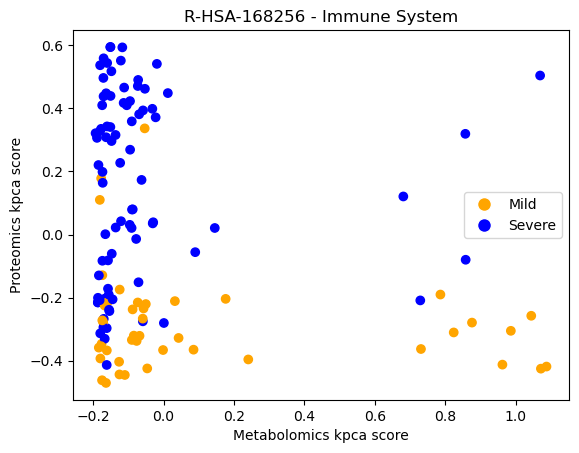

In [36]:
scatter = plt.scatter(metab_kpca.loc[:, 'R-HSA-168256'], prot_kpca.loc[:, 'R-HSA-168256'],
                      c=['orange' if i == 0 else 'blue' for i in metadata_binary])

# Create legend manually
mild_patch = plt.Line2D([], [], marker='o', color='w', label='Mild', markerfacecolor='orange', markersize=10)
severe_patch = plt.Line2D([], [], marker='o', color='w', label='Severe', markerfacecolor='blue', markersize=10)
plt.legend(handles=[mild_patch, severe_patch])

# Add labels and title
plt.xlabel('Metabolomics kpca score')
plt.ylabel('Proteomics kpca score')
plt.title('R-HSA-168256 - Immune System')
plt.show()

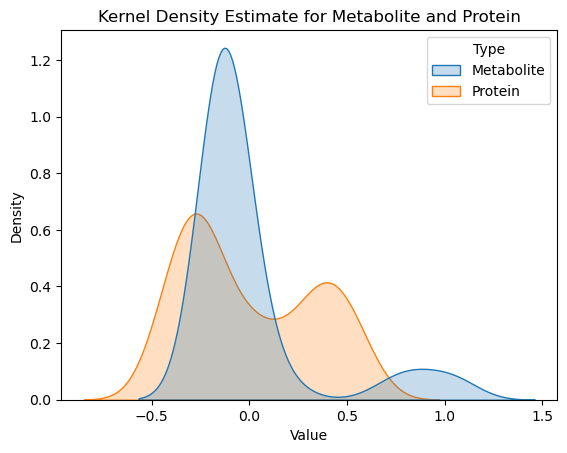

In [37]:
metab_data = metab_kpca.loc[:, 'R-HSA-168256']
prot_data = prot_kpca.loc[:, 'R-HSA-168256']

# Create a DataFrame for Seaborn
data_to_plot = pd.DataFrame({
    'Metabolite': metab_data,
    'Protein': prot_data
})

# Melt the DataFrame for seaborn
data_melted = data_to_plot.melt(var_name='Type', value_name='Value')

# Create the kernel density plot
sns.kdeplot(data=data_melted, x='Value', hue='Type', fill=True)

# Add titles and labels
plt.title('Kernel Density Estimate for Metabolite and Protein')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()

(array([89., 19.,  4.,  1.,  0.,  0.,  1.,  4.,  3.,  6.]),
 array([-0.1931243 , -0.06505768,  0.06300893,  0.19107554,  0.31914216,
         0.44720877,  0.57527539,  0.703342  ,  0.83140862,  0.95947523,
         1.08754185]),
 <BarContainer object of 10 artists>)

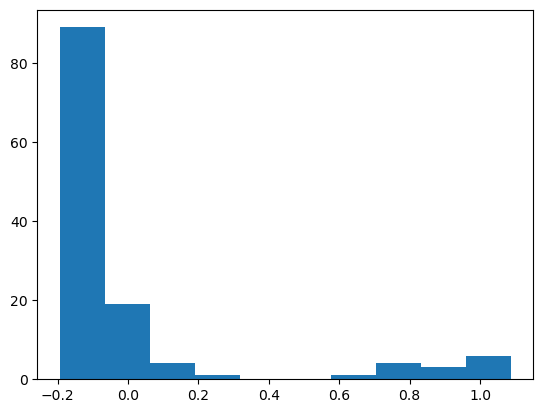

In [38]:
plt.hist(metab_kpca.loc[:, 'R-HSA-168256'])

In [39]:
np.std(prot_kpca.loc[:, 'R-HSA-168256'])

0.32988400689455966

'R-HSA-6806667': 'Metabolism of fat-soluble vitamins'

In [40]:
intersection = set(prot.columns).intersection(set(prot_path_dict['R-HSA-6806667']))
intersection

{'LPL', 'LRP1', 'SDC4'}

In [41]:
intersection = set(metab.columns).intersection(set(metab_path_dict['R-HSA-6806667']))
intersection

{'15756', '17351', '18145'}

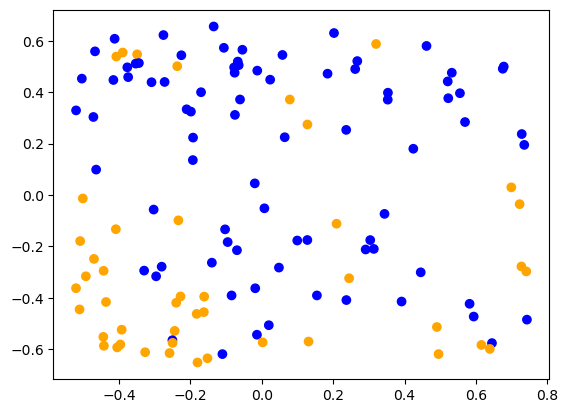

In [42]:
plt.scatter(metab_kpca.loc[:,'R-HSA-6806667'], prot_kpca.loc[:,'R-HSA-6806667'],c=['orange' if i ==0 else 'blue' for i in metadata_binary])

'R-HSA-8957322': 'Metabolism of steroids'

In [43]:
intersect = set(prot.columns).intersection(set(prot_path_dict['R-HSA-8957322']))

In [59]:
metab_ster_df = prot.loc[:,prot.columns.isin(intersect)]

In [57]:
prot_kpca.loc[:,'R-HSA-8957322'].idxmin()

'INCOV066-BL'

In [65]:
sorted_unique_values = prot_kpca['R-HSA-8957322'].drop_duplicates().sort_values()

# Check if there is a second minimum
if len(sorted_unique_values) > 1:
    second_min_value = sorted_unique_values.iloc[1]  # Get the second minimum value
    second_min_index = prot_kpca[prot_kpca['R-HSA-8957322'] == second_min_value].index[0]  # Get the index of the second minimum
else:
    second_min_index = None  # Handle the case when there is no second minimum

print(second_min_index)

INCOV083-BL


In [58]:
prot_kpca.loc[:,'R-HSA-8957322'].idxmax()

'INCOV043-BL'

In [72]:
prot_kpca.loc[:,'R-HSA-8957322'].abs().idxmin()

'INCOV082-BL'

In [73]:
metab_ster_df_filtered = metab_ster_df.loc[['INCOV066-BL','INCOV083-BL','INCOV043-BL','INCOV082-BL']]

In [74]:
metab_ster_df_filtered

,FABP6,HSD11B1,LHB,MVK
sample_id,,,,
INCOV066-BL,2.341949,3.575884,2.132289,6.723778
INCOV083-BL,2.958985,3.139353,2.581747,7.550852
INCOV043-BL,2.623357,3.307746,3.063402,3.715317
INCOV082-BL,2.758390,3.062793,3.456799,5.538740


In [68]:
prot.loc[:,'FABP6'].mean()

2.3647880133283623

In [70]:
prot.loc[:,'HSD11B1'].mean()

3.2876039281086245

In [63]:
prot.loc[:,'LHB'].mean()

2.7735277360059283

In [64]:
prot.loc[:,'MVK'].mean()

5.532253229808237

In [ ]:
intersection = set(metab.columns).intersection(set(metab_path_dict['R-HSA-8957322']))
intersection

{'15756',
 '15891',
 '16238',
 '16359',
 '16525',
 '16827',
 '16962',
 '16990',
 '17351',
 '28834',
 '28865'}

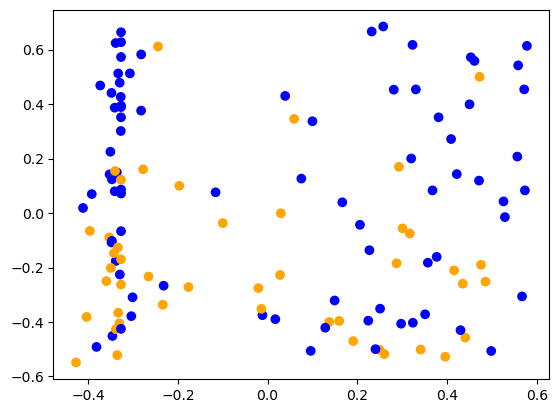

In [ ]:
plt.scatter(metab_kpca.loc[:,'R-HSA-8957322'], prot_kpca.loc[:,'R-HSA-8957322'],c=['orange' if i ==0 else 'blue' for i in metadata_binary])

'R-HSA-2980736': 'Peptide hormone metabolism'

In [ ]:
intersection = set(prot.columns).intersection(set(prot_path_dict['R-HSA-2980736']))
intersection

{'ACE2', 'ATP6AP2', 'GH1', 'GHRL', 'LEP', 'LHB', 'REN', 'TSHB'}

In [ ]:
intersection = set(metab.columns).intersection(set(metab_path_dict['R-HSA-2980736']))
intersection

{'15756', '28716', '28875', '30805'}

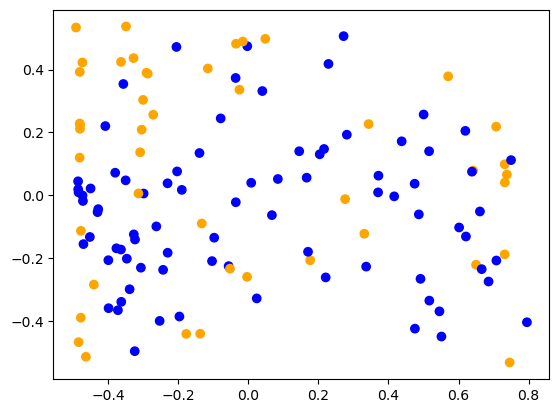

In [ ]:
plt.scatter(metab_kpca.loc[:,'R-HSA-2980736'], prot_kpca.loc[:,'R-HSA-2980736'],c=['orange' if i ==0 else 'blue' for i in metadata_binary])

'R-HSA-381340': 'Transcriptional regulation of white adipocyte differentiation'

In [ ]:
intersection = set(prot.columns).intersection(set(prot_path_dict['R-HSA-381340']))
intersection

{'LEP', 'LPL', 'PLIN1', 'TGFB1', 'TNF'}

In [ ]:
intersection = set(metab.columns).intersection(set(metab_path_dict['R-HSA-381340']))
intersection

{'15756', '16990', '17351'}

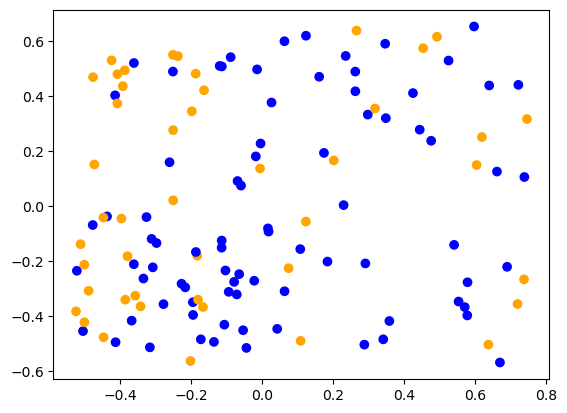

In [ ]:
plt.scatter(metab_kpca.loc[:,'R-HSA-381340'], prot_kpca.loc[:,'R-HSA-381340'],c=['orange' if i ==0 else 'blue' for i in metadata_binary])